# Import libraries

For scraping I will use BeautifulSoup, and will compile data into pandas dataframes for analysis

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib

# Scrape data

For this initial challenge EDA, I will focus solely on data science positions (I love data science, duh!) but the intention is to extend this project to include all H-1B visa beneficiaries. 

Define function to request specific job positions:

In [9]:
def scrape_data(position):
    a = position.lower().split()[0]
    b = position.lower().split()[1]
    
    req = urllib.request.urlopen('https://h1bdata.info/index.php?em=&job='+ a +'+'+ b +'&city=&year=All+Years') 
    soup = BeautifulSoup(req, "lxml")
    
    rows = soup.find_all('tr') 
    headings = []
    for h in rows[0].find_all('th'):
        headings.append(h.get_text().strip().lower())
        
    compiled_data = []
    
    for data in rows[1:]:
        data_list = []
        for d in data.find_all('td'):
            d_string = d.get_text().replace(',','')
            
            if d_string.isnumeric():
                data_list.append(int(d_string))
            else:
                data_list.append(d_string)
        compiled_data.append(data_list)        
        
    df = pd.DataFrame(compiled_data, columns = headings)
    df['submit date'] = pd.to_datetime(df['submit date'])
    df['start date'] = pd.to_datetime(df['start date'])
    df['state'] = df['location'].str.split().str[-1]
    df['year'] = df['submit date'].dt.year
    df['month'] = df['submit date'].dt.month
    
    return df    
            
                

### Compile 'data scientist' job data

In [15]:
data_scientists = scrape_data('data scientist')

In [16]:
data_scientists.head()

,employer,job title,base salary,location,submit date,start date,case status,state,year,month
0,PERCOLATA CORPORATION,DATA SCIENTIST,46060,PALO ALTO CA,2016-03-18,2016-09-02,CERTIFIED,CA,2016,3
1,MY LIFE REGISTRY LLC,DATA SCIENTIST,47960,FORT LEE NJ,2015-02-18,2015-08-20,CERTIFIED,NJ,2015,2
2,MY LIFE REGISTRY LLC,DATA SCIENTIST,47960,FORT LEE NJ,2015-02-18,2015-08-20,CERTIFIED,NJ,2015,2
3,BIG DATA ANALYTICS TRADING INC,DATA SCIENTIST,50000,JOHNS CREEK GA,2017-03-16,2017-09-01,CERTIFIED,GA,2017,3
4,YONO HEALTH INC,DATA SCIENTIST,50220,SUNNYVALE CA,2017-02-28,2017-08-28,CERTIFIED,CA,2017,2


In [17]:
data_scientists.shape

(4947, 10)

The number of entries is low (~5000). However, for the purposes of this challenge I will continue to work with this data. During scraping I noticed some data scientist positions had slight variations in their titles so the  ``` scrape_data```  function above does not return them when searching specifically for the term **'data scientist'**. I'll develop this further during the Fellowship bootcamp.

# Check yearly salary trend

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [18]:
for_plot = data_scientists.pivot_table('base salary', index='year', columns = 'job title', aggfunc = 'median')

In [22]:
print(for_plot.shape)
print(for_plot)

(6, 1)
job title  DATA SCIENTIST
year                     
2013               115000
2014               110000
2015               108650
2016               104042
2017               104343
2018               102500


In [68]:
x_axis = for_plot.index.astype('int')
y_axis = for_plot['DATA SCIENTIST'].values

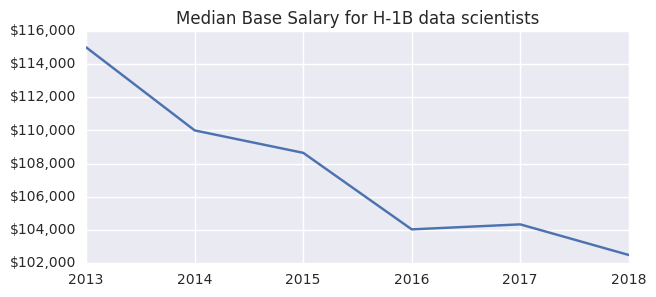

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))
ax.plot(x_axis,y_axis)
y_formatter = ticker.StrMethodFormatter('${x:,.0f}')
x_formatter = ticker.FormatStrFormatter('%1.0f')
ax.yaxis.set_major_formatter(y_formatter)
ax.xaxis.set_major_formatter(x_formatter)
plt.title('Median Base Salary for H-1B data scientists')
plt.show()

# Preliminary geographical check of data scientist H-1B positions 

In [122]:
import string as st
import numpy as np
import seaborn as sns

In [166]:
def top_states(df):
    positions_per_state = df.groupby('state')['employer'].aggregate({'issued': 'count', \
                      'employers': 'nunique'}).sort_values(by = 'issued', ascending = False)
    positions_per_state = positions_per_state[:10]

    # Top 10 states that issued H-1B visas
    title = st.capwords(df['job title'][0].lower())    
    ind = np.arange(len(positions_per_state['issued']))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(13,8))
    
    rect1 = ax.bar(ind-width/2, positions_per_state['issued'], width, color='Blue', label = 'Visas issued')
    rect2 = ax.bar(ind+width/2, positions_per_state['employers'], width, color='Red', label = '# of employers sponsoring visas')
    
    ax.set_ylabel('Visas issued (blue) and employers issuing (red) per state')
    ax.set_title('Top 10 states issuing H-1B visas for data scientists, by total visas issued')
    ax.set_xticks(ind)
    ax.set_xticklabels(tuple(positions_per_state.index.get_values()))
    ax.legend()
    
    return fig

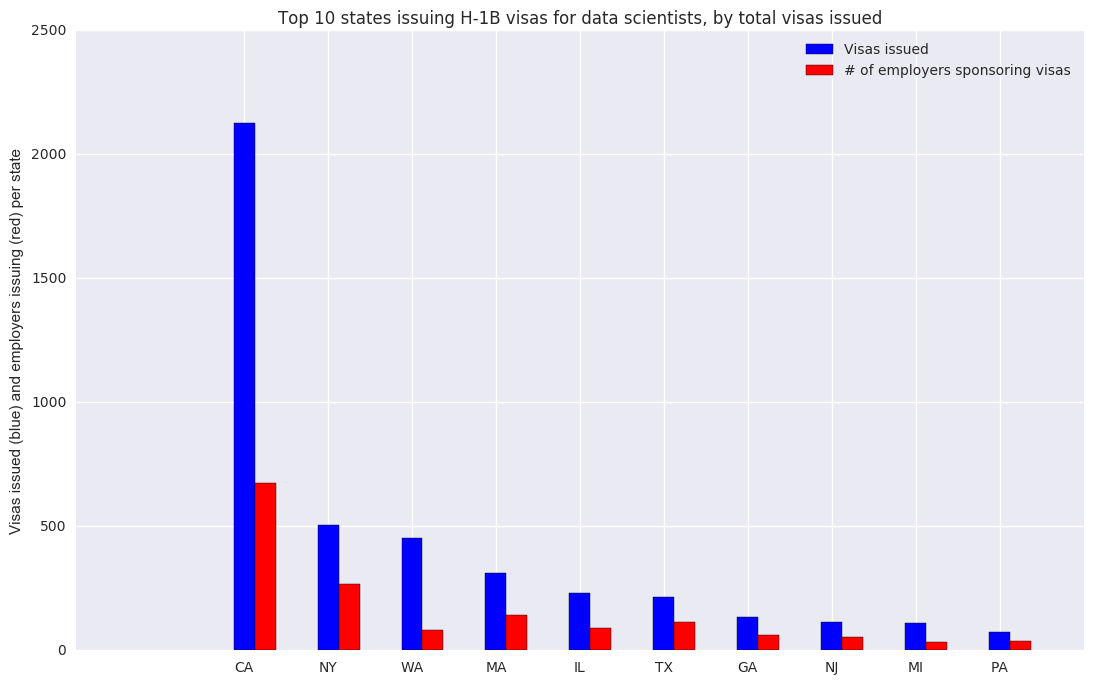

In [167]:
plt.show(top_states(data_scientists))

# Estimate size of dataframe

In [93]:
import sys

In [113]:
Total_size_MB = 0

for column in data_scientists.columns:
    MB_size = sum([ sys.getsizeof(v) for v in data_scientists[column].values ])/1e+6
    print('Column \'' + column + '\' size (MB): ' + str(MB_size))
    Total_size_MB = Total_size_MB + MB_size
    
print('_'*40)
print("Total size (MB): {:1.3f}".format(Total_size_MB))

Column 'employer' size (MB): 0.329811
Column 'job title' size (MB): 0.311691
Column 'base salary' size (MB): 0.158304
Column 'location' size (MB): 0.303485
Column 'submit date' size (MB): 0.19788
Column 'start date' size (MB): 0.19788
Column 'case status' size (MB): 0.286785
Column 'state' size (MB): 0.252297
Column 'year' size (MB): 0.158304
Column 'month' size (MB): 0.158304
________________________________________
Total size (MB): 2.355


In [98]:
data_scientists.memory_usage()

Index             80
employer       39576
job title      39576
base salary    39576
location       39576
submit date    39576
start date     39576
case status    39576
state          39576
year           39576
month          39576
dtype: int64